In [10]:
import numpy as np
from PIL import Image
import os
from pathlib import Path

In [16]:
# Define the background colors to exclude (mask out)
background_colors = [
    (24, 24, 24, 255),      # Dark gray background
    (168, 168, 168, 255)    # Light gray background
]

# Path to your PNG annotation file
png_path = r"C:\Users\meloy\Downloads\Mask_Manual.png" # Update this with your actual PNG file path
output_mask_path = r"C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy"  # Update this with desired output path

In [17]:
def create_mask_from_png(png_path, background_colors, target_shape=None):
    """
    Create a binary mask from a PNG file.
    
    Parameters:
    -----------
    png_path : str
        Path to the PNG annotation file
    background_colors : list of tuples
        RGBA values to be masked out (set to False/0)
    target_shape : tuple, optional
        Target shape (height, width) to resize the mask to
    
    Returns:
    --------
    numpy.ndarray
        Binary mask where True/1 indicates regions to analyze, False/0 for background
    """
    # Load the PNG image
    img = Image.open(png_path)
    
    # Convert to RGBA if not already
    if img.mode != 'RGBA':
        img = img.convert('RGBA')
    
    # Convert to numpy array
    img_array = np.array(img)
    
    # Initialize mask with all True (include everything by default)
    mask = np.ones((img_array.shape[0], img_array.shape[1]), dtype=bool)
    
    # Set background pixels to False
    for bg_color in background_colors:
        # Check where all RGBA channels match the background color
        matches = np.all(img_array == bg_color, axis=2)
        mask[matches] = False
    
    # Resize mask if target_shape is specified
    if target_shape is not None:
        target_h, target_w = target_shape
        current_h, current_w = mask.shape
        
        if (current_h, current_w) != (target_h, target_w):
            # Create new mask with target shape, default to False (background)
            resized_mask = np.zeros((target_h, target_w), dtype=bool)
            
            # Calculate padding or cropping needed
            h_diff = target_h - current_h
            w_diff = target_w - current_w
            
            if h_diff >= 0 and w_diff >= 0:
                # Padding needed - center the original mask
                h_pad = h_diff // 2
                w_pad = w_diff // 2
                resized_mask[h_pad:h_pad+current_h, w_pad:w_pad+current_w] = mask
            elif h_diff >= 0 and w_diff < 0:
                # Pad height, crop width
                h_pad = h_diff // 2
                w_crop = abs(w_diff) // 2
                resized_mask[h_pad:h_pad+current_h, :] = mask[:, w_crop:w_crop+target_w]
            elif h_diff < 0 and w_diff >= 0:
                # Crop height, pad width
                h_crop = abs(h_diff) // 2
                w_pad = w_diff // 2
                resized_mask[:, w_pad:w_pad+current_w] = mask[h_crop:h_crop+target_h, :]
            else:
                # Crop both dimensions
                h_crop = abs(h_diff) // 2
                w_crop = abs(w_diff) // 2
                resized_mask = mask[h_crop:h_crop+target_h, w_crop:w_crop+target_w]
            
            mask = resized_mask
            print(f"Resized mask from {(current_h, current_w)} to {mask.shape}")
    
    return mask

In [18]:
# Create the mask with target shape (1040, 1392)
target_shape = (1040, 1392)  # Adjust height from 1024 to 1040
mask = create_mask_from_png(png_path, background_colors, target_shape=target_shape)

# Print mask information
print(f"Mask shape: {mask.shape}")
print(f"Number of pixels to analyze (True): {np.sum(mask)}")
print(f"Number of background pixels (False): {np.sum(~mask)}")
print(f"Percentage of image to analyze: {np.sum(mask) / mask.size * 100:.2f}%")

Resized mask from (1024, 1392) to (1040, 1392)
Mask shape: (1040, 1392)
Number of pixels to analyze (True): 327459
Number of background pixels (False): 1120221
Percentage of image to analyze: 22.62%


In [20]:
# Save the mask as .npy file
np.save(output_mask_path, mask)
print(f"Mask saved to: {output_mask_path}")

Mask saved to: C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy


IndexError: boolean index did not match indexed array along axis 0; size of axis is 1024 but size of corresponding boolean axis is 1040

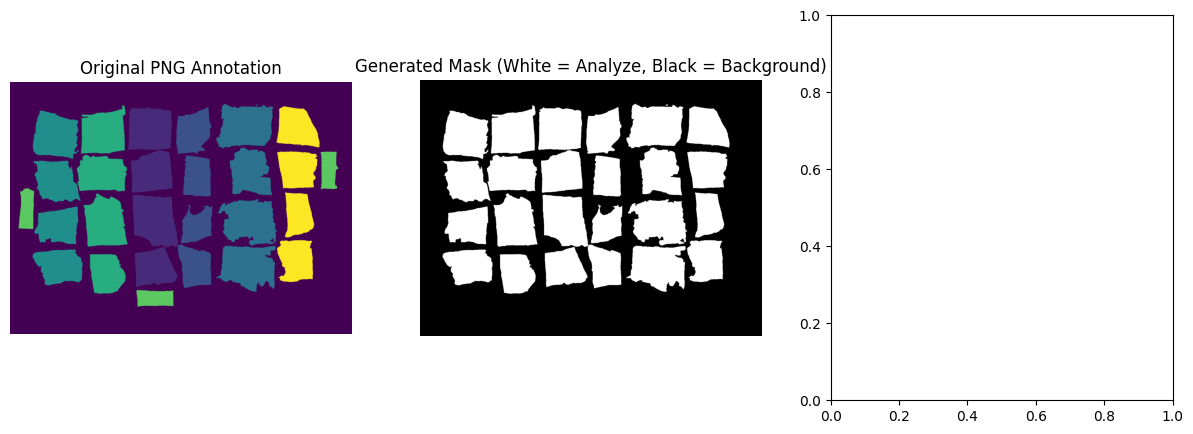

In [12]:
# Optional: Visualize the mask
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Load and show original PNG
img = Image.open(png_path)
axes[0].imshow(img)
axes[0].set_title("Original PNG Annotation")
axes[0].axis('off')

# Show mask
axes[1].imshow(mask, cmap='gray')
axes[1].set_title("Generated Mask (White = Analyze, Black = Background)")
axes[1].axis('off')

# Overlay mask on original
img_array = np.array(img.convert('RGB'))
masked_img = img_array.copy()
masked_img[~mask] = [255, 0, 0]  # Show masked regions in red
axes[2].imshow(masked_img)
axes[2].set_title("Overlay (Red = Masked Out)")
axes[2].axis('off')

plt.tight_layout()
plt.show()

## Batch Processing for Multiple Lichens Files

In [ ]:
# Batch processing for Lichens dataset with target shape
lichens_annotations_dir = "path/to/lichens/annotations"  # Update with your directory
lichens_masks_dir = "path/to/lichens/masks"  # Output directory for masks
target_shape = (1040, 1392)  # Target mask shape

# Create output directory if it doesn't exist
os.makedirs(lichens_masks_dir, exist_ok=True)

# Process all PNG files in the directory
png_files = list(Path(lichens_annotations_dir).glob("*.png"))

for png_file in png_files:
    # Create mask with target shape
    mask = create_mask_from_png(str(png_file), background_colors, target_shape=target_shape)
    
    # Save with same name but .npy extension
    mask_filename = png_file.stem + "_mask.npy"
    mask_path = Path(lichens_masks_dir) / mask_filename
    np.save(mask_path, mask)
    
    print(f"Processed: {png_file.name} -> {mask_filename}")
    print(f"  Mask shape: {mask.shape}, Analysis pixels: {np.sum(mask):,}")

print(f"\nTotal masks created: {len(png_files)}")
print(f"Masks saved to: {lichens_masks_dir}")